# ANALYSIS OF MENTAL FITNESS (PART - II)

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# PreProcessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Splitting Data
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.ensemble import AdaBoostClassifier

# Tuning
from sklearn.model_selection import RandomizedSearchCV

# Deployment
import pickle

In [2]:
df = pd.read_csv('survey.csv')
pd.set_option("display.max_rows", None)

In [3]:
df.shape

(1259, 27)

In [4]:
df.drop(columns=['Timestamp', 'Country', 'state', 'comments'], inplace = True)

In [5]:
df.rename({'self_employed' : 'Self_Employed', 'family_history' : 'Family_History', 
           'treatment' : 'Treatment', 'work_interfere' : 'Work_Interfere', 
           'no_employees': 'Employee_Numbers', 'remote_work': 'Remote_Work', 'tech_company': 'Tech_Company', 
           'benefits': 'Benefits', 'care_options': 'Care_Options', 'wellness_program': 'Wellness_Program', 
           'seek_help': 'Seek_Help', 'anonymity': 'Anonymity', 'leave': 'Medical_Leave', 
           'mental_health_consequence': 'Mental_Health_Consequence', 
           'phys_health_consequence': 'Physical_Health_Consequence', 'coworkers': 'Coworkers', 
           'supervisor': 'Supervisor', 'mental_health_interview': 'Mental_Health_Interview', 
           'phys_health_interview': 'Physical_Health_Interview', 'mental_vs_physical': 'Mental_VS_Physical', 
           'obs_consequence': 'Observed_Consequence'} , inplace = True , axis = 1)

In [6]:
df['Gender'].replace(['Male ', 'male', 'M', 'm', 'Male', 'Cis Male',
                     'Man', 'cis male', 'Mail', 'Male-ish', 'Male (CIS)',
                      'Cis Man', 'msle', 'Malr', 'Mal', 'maile', 'Make',], 'Male', inplace = True)

df['Gender'].replace(['Female ', 'female', 'F', 'f', 'Woman', 'Female',
                     'femail', 'Cis Female', 'cis-female/femme', 'Femake', 'Female (cis)',
                     'woman',], 'Female', inplace = True)

df["Gender"].replace(['Female (trans)', 'queer/she/they', 'non-binary',
                     'fluid', 'queer', 'Androgyne', 'Trans-female', 'male leaning androgynous',
                      'Agender', 'A little about you', 'Nah', 'All',
                      'ostensibly male, unsure what that really means',
                      'Genderqueer', 'Enby', 'p', 'Neuter', 'something kinda male?',
                      'Guy (-ish) ^_^', 'Trans woman',], 'Queer', inplace = True)

In [7]:
defaultString = 'NaN'
df['Self_Employed'] = df['Self_Employed'].fillna(defaultString)
df['Self_Employed'] = df['Self_Employed'].replace([defaultString], 'No')
print(df['Self_Employed'].unique())

['No' 'Yes']


In [8]:
df['Age'].replace([df['Age'][df['Age'] < 15]], np.nan, inplace = True)
df['Age'].replace([df['Age'][df['Age'] > 100]], np.nan, inplace = True)

df['Age'].unique()

array([37., 44., 32., 31., 33., 35., 39., 42., 23., 29., 36., 27., 46.,
       41., 34., 30., 40., 38., 50., 24., 18., 28., 26., 22., 19., 25.,
       45., 21., nan, 43., 56., 60., 54., 55., 48., 20., 57., 58., 47.,
       62., 51., 65., 49., 53., 61., 72.])

### PRE-PROCESSING

In [9]:
mode_onehot_pipe = Pipeline([
    ('encoder', SimpleImputer(strategy = 'most_frequent')),
    ('one hot encoder', OneHotEncoder(handle_unknown = 'ignore'))])

transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(handle_unknown = 'ignore'), ['Gender', 'Family_History', 'Employee_Numbers',
                                                           'Remote_Work', 'Tech_Company', 'Benefits', 'Care_Options',
                                                           'Wellness_Program', 'Seek_Help', 'Anonymity',
                                                           'Medical_Leave', 'Mental_Health_Consequence',
                                                           'Physical_Health_Consequence', 'Coworkers', 'Supervisor',
                                                           'Mental_Health_Interview', 'Physical_Health_Interview',
                                                           'Mental_VS_Physical', 'Observed_Consequence']),
    ('mode_onehot_pipe', mode_onehot_pipe, ['Self_Employed', 'Work_Interfere']),
    ('iterative', IterativeImputer(max_iter = 10, random_state = 0), ['Age'])])

In [10]:
df['Gender']

0       Female
1         Male
2         Male
3         Male
4         Male
5         Male
6       Female
7         Male
8       Female
9         Male
10        Male
11        Male
12      Female
13        Male
14        Male
15      Female
16        Male
17        Male
18        Male
19        Male
20        Male
21        Male
22        Male
23        Male
24        Male
25        Male
26        Male
27      Female
28        Male
29        Male
30        Male
31        Male
32        Male
33        Male
34      Female
35        Male
36        Male
37        Male
38        Male
39        Male
40        Male
41        Male
42        Male
43        Male
44        Male
45      Female
46        Male
47        Male
48        Male
49        Male
50        Male
51        Male
52        Male
53        Male
54        Male
55        Male
56        Male
57        Male
58        Male
59        Male
60        Male
61      Female
62        Male
63        Male
64        Male
65        Male
66      Fe

#### DEFINE THE TARGET DATA

In [11]:

df['Treatment'].value_counts()/df.shape[0]*100


Yes    50.595711
No     49.404289
Name: Treatment, dtype: float64

In [12]:
df['Treatment'] = np.where(df['Treatment'] == 'Yes', 1, 0)

0 = No Treatment
1 = Gotten Treatment

In [13]:
X = df.drop('Treatment', axis = 1)
y = df['Treatment']

### SPLITTING DATA

In [14]:
X.shape

(1259, 22)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = 0)

### MODEL DEFINITION

In [16]:
logreg = LogisticRegression()
tree = DecisionTreeClassifier(random_state = 0)
ada = AdaBoostClassifier(random_state = 0)


### MODEL EVALUATION

In [17]:
logreg_pipe = Pipeline([('transformer', transformer), ('logreg', logreg)])
tree_pipe = Pipeline([('transformer', transformer), ('tree', tree)])
ada_pipe = Pipeline([('transformer', transformer), ('ada', ada)])

def model_evaluation(model, metric):
    model_cv = cross_val_score(model, X_train, y_train, cv = StratifiedKFold(n_splits = 5), scoring = metric)
    return model_cv

logreg_pipe_cv = model_evaluation(logreg_pipe, 'accuracy')
tree_pipe_cv = model_evaluation(tree_pipe, 'accuracy')
ada_pipe_cv = model_evaluation(ada_pipe, 'accuracy')

for model in [logreg_pipe, tree_pipe, ada_pipe]:
    model.fit(X_train, y_train)

score_cv = [logreg_pipe_cv.round(5), tree_pipe_cv.round(5),  ada_pipe_cv.round(5)]

score_mean = [logreg_pipe_cv.mean(), tree_pipe_cv.mean(),  ada_pipe_cv.mean()]

score_std = [logreg_pipe_cv.std(), tree_pipe_cv.std(),  ada_pipe_cv.std()]

score_accuracy_score = [accuracy_score(y_test, logreg_pipe.predict(X_test)),
                      accuracy_score(y_test, tree_pipe.predict(X_test)), 
                      accuracy_score(y_test, ada_pipe.predict(X_test))]
  
method_name = ['Logistic Regression', 'Decision Tree Classifier',  'Ada Boost Classifier']

cv_summary = pd.DataFrame({
    'method': method_name,
    'cv score': score_cv,
    'mean score': score_mean,
    'std score': score_std,
    'accuracy score': score_accuracy_score
})
cv_summary

,method,cv score,mean score,std score,accuracy score
0,Logistic Regression,"[0.74011, 0.74432, 0.6875, 0.72159, 0.77841]",0.734386,0.029771,0.748677
1,Decision Tree Classifier,"[0.71751, 0.70455, 0.63068, 0.63636, 0.72727]",0.683276,0.041297,0.648148
2,Ada Boost Classifier,"[0.75141, 0.71023, 0.68182, 0.72727, 0.74432]",0.723010,0.025056,0.735450


### HYPERPARAMETER TUNING

In [18]:
lr_estimator = Pipeline([
    ('transformer', transformer),
    ('model', logreg)])

hyperparam_space = {
    'model__C' : [1, 5, 10, 50, 100],
    'model__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'model__class_weight': ['balanced', 'dict'],
    'model__penalty':['none', 'l1', 'l2', 'elasticnet'],
    'model__random_state': [0]
}

rs_lr = RandomizedSearchCV(
                lr_estimator,
                hyperparam_space,
                cv = StratifiedKFold(n_splits = 5),
                scoring = 'accuracy',
                n_jobs = -1)

rs_lr.fit(X_train, y_train)

print('best score', rs_lr.best_score_)
print('best param', rs_lr.best_params_)



best score 0.7287172573189522
best param {'model__solver': 'lbfgs', 'model__random_state': 0, 'model__penalty': 'none', 'model__class_weight': 'balanced', 'model__C': 10}


In [19]:
logreg_pipe.fit(X_train, y_train)
accuracy_logreg = (accuracy_score(y_test, logreg_pipe.predict(X_test)))

rs_lr.best_estimator_.fit(X_train, y_train)
accuracy_grid = (accuracy_score(y_test, rs_lr.predict(X_test)))

score_list = [accuracy_logreg, accuracy_grid]
method_name = ['Logistic Regression Before Tuning','Logistic Regression After Tuning']
best_summary = pd.DataFrame({
    'method': method_name,
    'score': score_list
})
best_summary

,method,score
0,Logistic Regression Before Tuning,0.748677
1,Logistic Regression After Tuning,0.746032


### FEATURE SELECTION USING COEFFICIENT SCORE

In [20]:
transformer.transformers_

[('one hot',
  OneHotEncoder(handle_unknown='ignore'),
  ['Gender',
   'Family_History',
   'Employee_Numbers',
   'Remote_Work',
   'Tech_Company',
   'Benefits',
   'Care_Options',
   'Wellness_Program',
   'Seek_Help',
   'Anonymity',
   'Medical_Leave',
   'Mental_Health_Consequence',
   'Physical_Health_Consequence',
   'Coworkers',
   'Supervisor',
   'Mental_Health_Interview',
   'Physical_Health_Interview',
   'Mental_VS_Physical',
   'Observed_Consequence']),
 ('mode_onehot_pipe',
  Pipeline(steps=[('encoder', SimpleImputer(strategy='most_frequent')),
                  ('one hot encoder', OneHotEncoder(handle_unknown='ignore'))]),
  ['Self_Employed', 'Work_Interfere']),
 ('iterative', IterativeImputer(random_state=0), ['Age'])]

In [21]:
transformer.transformers_[0][1].get_feature_names_out()

array(['Gender_Female', 'Gender_Male', 'Gender_Queer',
       'Family_History_No', 'Family_History_Yes', 'Employee_Numbers_1-5',
       'Employee_Numbers_100-500', 'Employee_Numbers_26-100',
       'Employee_Numbers_500-1000', 'Employee_Numbers_6-25',
       'Employee_Numbers_More than 1000', 'Remote_Work_No',
       'Remote_Work_Yes', 'Tech_Company_No', 'Tech_Company_Yes',
       "Benefits_Don't know", 'Benefits_No', 'Benefits_Yes',
       'Care_Options_No', 'Care_Options_Not sure', 'Care_Options_Yes',
       "Wellness_Program_Don't know", 'Wellness_Program_No',
       'Wellness_Program_Yes', "Seek_Help_Don't know", 'Seek_Help_No',
       'Seek_Help_Yes', "Anonymity_Don't know", 'Anonymity_No',
       'Anonymity_Yes', "Medical_Leave_Don't know",
       'Medical_Leave_Somewhat difficult', 'Medical_Leave_Somewhat easy',
       'Medical_Leave_Very difficult', 'Medical_Leave_Very easy',
       'Mental_Health_Consequence_Maybe', 'Mental_Health_Consequence_No',
       'Mental_Health_Consequ

In [22]:
transformer.transformers_[1][1][1].get_feature_names_out()

array(['x0_No', 'x0_Yes', 'x1_Never', 'x1_Often', 'x1_Rarely',
       'x1_Sometimes'], dtype=object)

In [23]:
features = list(transformer.transformers_[0][1].get_feature_names())+list(transformer.transformers_[1][1][1].get_feature_names())+['Age']
coef_table = pd.DataFrame({'coef': rs_lr.best_estimator_[1].coef_.flatten()}, index = features)
abs(coef_table).sort_values('coef', ascending = False)


,coef
x1_Never,1.991358
x1_Often,1.698522
x10_Very difficult,0.728106
x1_No,0.653338
x13_No,0.644553
x1_Yes,0.640343
x13_Yes,0.588155
x6_Yes,0.552283
x10_Somewhat easy,0.540079
x0_Male,0.514734


<AxesSubplot:>

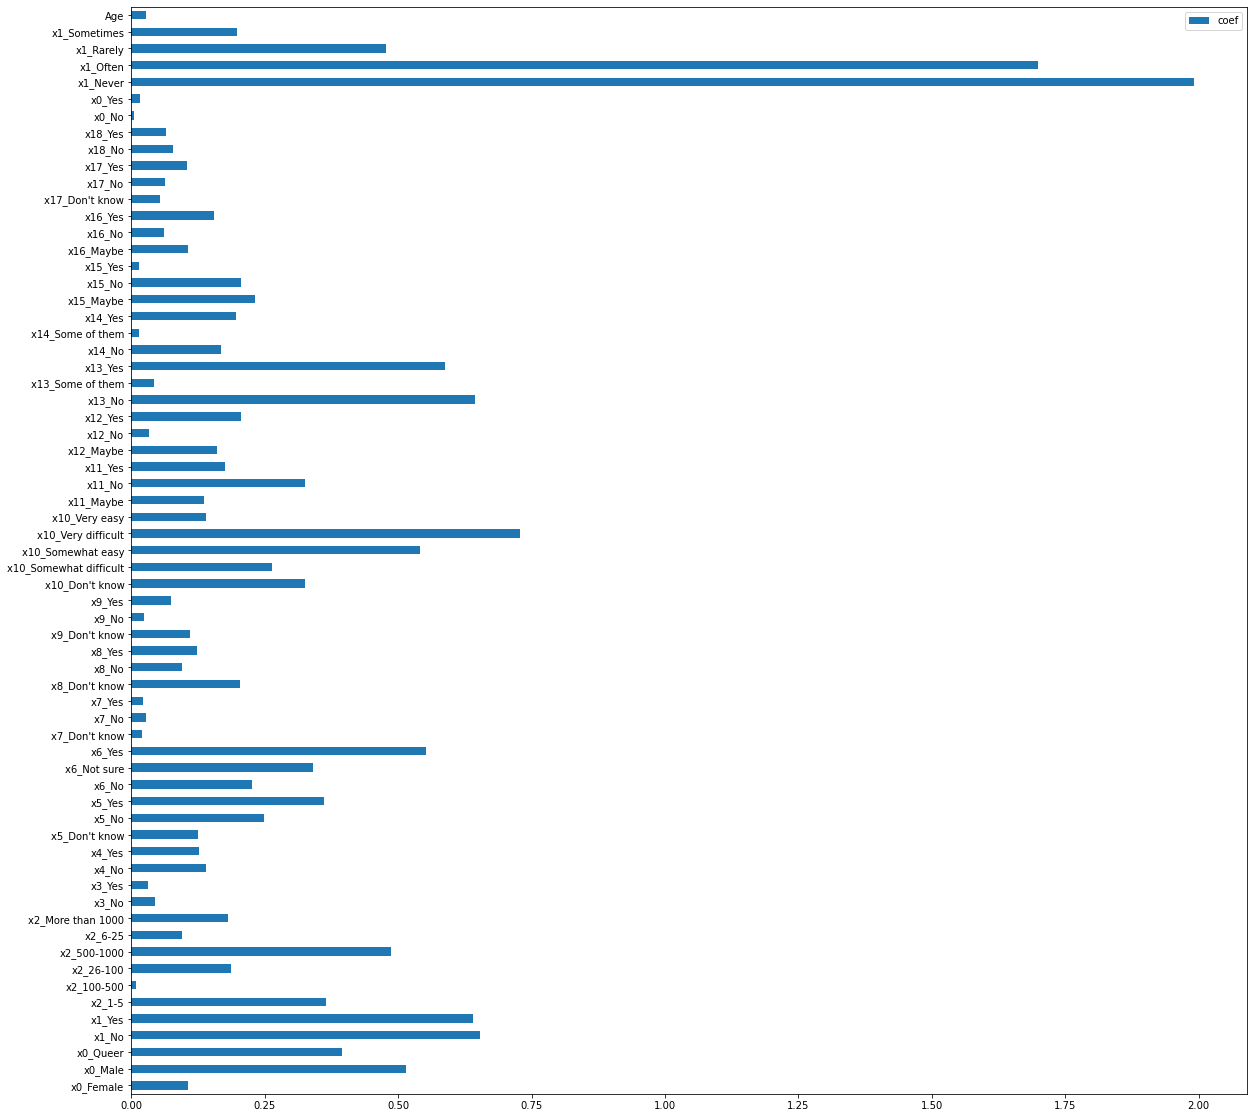

In [24]:
abs(coef_table).plot(kind = 'barh', figsize = (20,20))

In [25]:
df_tuning = df.copy()
df_tuning.drop(columns = ['Age', 'Remote_Work', 'Wellness_Program', 'Physical_Health_Consequence'], inplace = True)
df_tuning.head()

,Gender,Self_Employed,Family_History,Treatment,Work_Interfere,Employee_Numbers,Tech_Company,Benefits,Care_Options,Seek_Help,Anonymity,Medical_Leave,Mental_Health_Consequence,Coworkers,Supervisor,Mental_Health_Interview,Physical_Health_Interview,Mental_VS_Physical,Observed_Consequence
0,Female,No,No,1,Often,6-25,Yes,Yes,Not sure,Yes,Yes,Somewhat easy,No,Some of them,Yes,No,Maybe,Yes,No
1,Male,No,No,0,Rarely,More than 1000,No,Don't know,No,Don't know,Don't know,Don't know,Maybe,No,No,No,No,Don't know,No
2,Male,No,No,0,Rarely,6-25,Yes,No,No,No,Don't know,Somewhat difficult,No,Yes,Yes,Yes,Yes,No,No
3,Male,No,Yes,1,Often,26-100,Yes,No,Yes,No,No,Somewhat difficult,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,Male,No,No,0,Never,100-500,Yes,Yes,No,Don't know,Don't know,Don't know,No,Some of them,Yes,Yes,Yes,Don't know,No


In [26]:
mode_onehot_pipe_second = Pipeline([
    ('encoder', SimpleImputer(strategy = 'most_frequent')),
    ('one hot encoder', OneHotEncoder(handle_unknown = 'ignore'))])

transformer_second = ColumnTransformer([
    ('one hot', OneHotEncoder(handle_unknown = 'ignore'), ['Gender', 'Family_History', 'Employee_Numbers',
                                                           'Tech_Company', 'Benefits', 'Care_Options', 
                                                           'Seek_Help', 'Anonymity', 'Medical_Leave',
                                                           'Mental_Health_Consequence', 'Coworkers',
                                                           'Supervisor','Mental_Health_Interview',
                                                           'Physical_Health_Interview', 'Mental_VS_Physical',
                                                           'Observed_Consequence',]),
    ('mode_onehot_pipe', mode_onehot_pipe_second, ['Self_Employed', 'Work_Interfere']),])

In [27]:
X_select = df_tuning.drop('Treatment', axis = 1)
y_select = df_tuning['Treatment']

In [28]:
X_select_train, X_select_test, y_select_train, y_select_test = train_test_split(X_select,y_select,
                                                   stratify = y_select,
                                                    test_size = 0.3,
                                                   random_state = 2222)

### RESULT

In [29]:
logreg_second = LogisticRegression(C = 0.5, class_weight = 'dict', max_iter = 100, multi_class = 'auto', random_state = 2222, solver = 'newton-cg')

logreg_second_pipe = Pipeline([('transformer', transformer_second), ('model', logreg_second)])

logreg_second_pipe.fit(X_select_train, y_select_train)

print('After Feature Selection Process, the score is ', accuracy_score(y_select_test, logreg_second_pipe.predict(X_select_test)))

After Feature Selection Process, the score is  0.7275132275132276


### DEPLOYMENT

In [30]:
logreg_second_pipe.fit(X_select, y_select)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('one hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Family_History',
                                                   'Employee_Numbers',
                                                   'Tech_Company', 'Benefits',
                                                   'Care_Options', 'Seek_Help',
                                                   'Anonymity', 'Medical_Leave',
                                                   'Mental_Health_Consequence',
                                                   'Coworkers', 'Supervisor',
                                                   'Mental_Health_Interview',
                                                   'Physical_Health_Interview',
                                                   'Mental_VS_Physical',
                                      

In [31]:
pickle_out = open("MentalHealthClassifier.pkl","wb")
pickle.dump(logreg_second_pipe, pickle_out)
pickle_out.close()

In [32]:
loaded_model = pickle.load(open('MentalHealthClassifier.pkl','rb'))
loaded_model.predict(X_select_test)

array([0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,

In [33]:
prediction = pd.DataFrame({
    'Gender': ['Female'],
    'Self_Employed': ['No'],
    'Family_History': ['No'],
    'Work_Interfere': ['Often'],
    'Employee_Numbers': ['6-25'],
    'Tech_Company': ['Yes'],
    'Benefits': ['Yes'],
    'Care_Options': ['Not sure'],
    'Seek_Help': ['Yes'],
    'Anonymity': ['Yes'],
    'Medical_Leave': ['Somewhat easy'],
    'Mental_Health_Consequence': ['No'],
    'Coworkers': ['Some of them'],
    'Supervisor': ['Yes'],
    'Mental_Health_Interview': ['No'],
    'Physical_Health_Interview': ['Maybe'],
    'Mental_VS_Physical': ['Yes'],
    'Observed_Consequence': ['No']
})

In [34]:
prediction

,Gender,Self_Employed,Family_History,Work_Interfere,Employee_Numbers,Tech_Company,Benefits,Care_Options,Seek_Help,Anonymity,Medical_Leave,Mental_Health_Consequence,Coworkers,Supervisor,Mental_Health_Interview,Physical_Health_Interview,Mental_VS_Physical,Observed_Consequence
0,Female,No,No,Often,6-25,Yes,Yes,Not sure,Yes,Yes,Somewhat easy,No,Some of them,Yes,No,Maybe,Yes,No


In [35]:
loaded_model.predict(prediction)

array([1])